In [100]:
import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
from spacy.matcher import Matcher 
import networkx as nx
import matplotlib.pyplot as plt

nlp_es = spacy.load('es_core_news_sm') # para procesamiento de textos en español
nlp_en = spacy.load('en_core_web_sm') # para procesamiento de textos en inglés

# importar archivo con oraciones utilizando pandas (pd)
sentencias_candidatas = pd.read_csv("ejemploSPACY5.csv")
sentencias_candidatas.shape

# Realizar una muestra de oraciones
sentencias_candidatas['respuestas'].sample(5)


7     casa tiene puertas
14      patio tiene agua
8      casa tiene cocina
11      casa tiene patio
3        corazon es rojo
Name: respuestas, dtype: object

In [101]:
def get_entities(sent):
  ## Parte 1 En la primera porción de código, se han definifo variables vacías. 
  #prv_tok_dep y prv_tok_text contendrán la etiqueta de dependencia de la palabra anterior en la oración y 
  #la palabra anterior en sí, respectivamente. prefix y modifier contendrán el texto asociado con el sujeto o el objeto.
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # etiqueta de dependencia del token anterior en la oración
  prv_tok_text = ""   # token anterior en la oración

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp_es(sent):
    ## Parte 2
    #A continuación, recorreremos los tokens en la oración. Primero verificaremos si el token 
    #es un signo de puntuación o no. En caso de serlo, lo ignoraremos y pasaremos al siguiente token. Si el token
    #es parte de una palabra compuesta (etiqueta de dependencia = "compound"), lo mantendremos en la variable prefix. 
    #Una palabra compuesta es una combinación de varias palabras vinculadas para formar una palabra con un nuevo
    #significado (ejemplo: "pista de patinaje", "amante de los libros").
    # Si el token es un signo de puntuación, pase al siguiente token
    if tok.dep_ != "punct":
      # comprobar: token es una palabra compuesta o no
      if tok.dep_ == "compound":
        prefix = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # comprobar: el token es un modificador o no
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## Parte 3 Si el token es el sujeto, se capturará como la primera entidad en la variable ent1.
      #Las variables prefix, modifier, prv_tok_dep y prv_tok_text se restablecen.
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## Parte 4  Si el token es el objeto, se capturará como la segunda entidad en la variable ent2. 
      #Las variables prefix, modifier, prv_tok_dep y prv_tok_text se restablecen.
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## Parte 5 Una vez que se haya capturado el sujeto y el objeto en la oración, 
      #actualizaremos el token anterior y su etiqueta de dependencia.
      # actualizar variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################


  return [ent1.strip(), ent2.strip()]

In [103]:
get_entities("rojo es el amanecer")

['rojo', '']

In [59]:
def get_relation(sent):

  doc = nlp_es(sent)

  # objeto de la clase Matcher
  matcher = Matcher(nlp_es.vocab)

  # definir el patrón 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 


  for tok in doc:
    print(tok.text, "...", tok.dep_)
  displacy.render(doc, style="dep")

  return(span.text)

In [91]:
get_relation("la casa tiene una cocina muy amplia")

la ... det
casa ... nsubj
tiene ... ROOT
una ... det
cocina ... obj
muy ... advmod
amplia ... amod


'tiene'

In [61]:
pares_entidades = []
# con tqdm podemos mostrar una barra de progreso 
for i in tqdm(sentencias_candidatas["respuestas"]): 
  pares_entidades.append(get_entities(i))
# con tqdm podemos mostrar una barra de progreso
relaciones = [get_relation(i) for i in tqdm(sentencias_candidatas['respuestas'])] 

  0%|          | 0/15 [00:00<?, ?it/s]

casa ... nsubj
es ... cop
blanca ... ROOT


perro ... nsubj
es ... cop
grande ... ROOT


ventanas ... nsubj
estan ... ROOT
limpias ... obj


corazon ... nsubj
es ... cop
rojo ... ROOT


vida ... nsubj
es ... cop
bella ... ROOT


 33%|███▎      | 5/15 [00:00<00:00, 48.57it/s]

hogar ... nsubj
es ... cop
bonito ... ROOT


casa ... nsubj
tiene ... ROOT
ventanas ... obj


casa ... nsubj
tiene ... ROOT
puertas ... obj


casa ... nsubj
tiene ... ROOT
cocina ... obj


casa ... nsubj
tiene ... ROOT
sala ... obj


 67%|██████▋   | 10/15 [00:00<00:00, 48.08it/s]

casa ... nsubj
tiene ... ROOT
dormitorio ... obj


casa ... nsubj
tiene ... ROOT
patio ... obj


casa ... nsubj
tiene ... ROOT
garaje ... obj


garaje ... nsubj
tiene ... ROOT
herramentas ... obj


patio ... nsubj
tiene ... ROOT
agua ... obj


100%|██████████| 15/15 [00:00<00:00, 48.69it/s]


In [62]:
# extraer sujeto
fuente = [i[0] for i in pares_entidades]

# extraer objeto
objetivo = [i[1] for i in pares_entidades]

gc_df = pd.DataFrame({'fuente':fuente, 'objetivo':objetivo, 'arista':relaciones})
gc_df

,fuente,objetivo,arista
0,casa,,blanca
1,perro,,grande
2,ventanas,,estan
3,corazon,,rojo
4,vida,,bella
5,hogar,,bonito
6,casa,,tiene
7,casa,,tiene
8,casa,,tiene
9,casa,,tiene


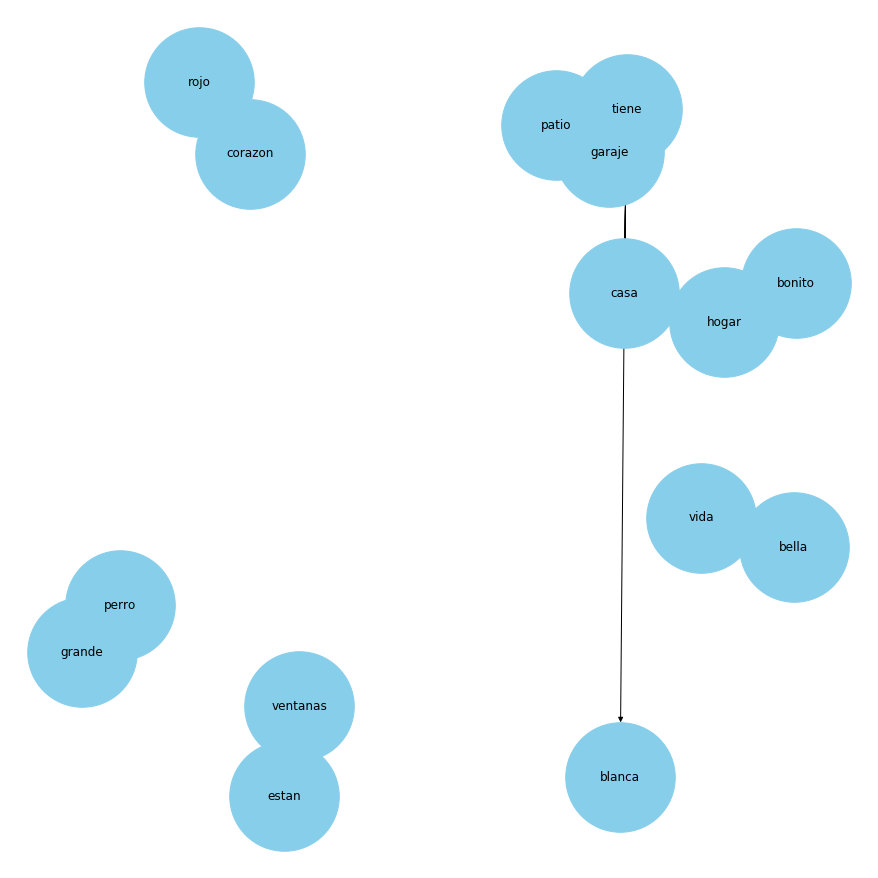

In [90]:
# crear un grafo dirigido desde un dataframe
G=nx.from_pandas_edgelist(gc_df, "fuente", "arista", edge_attr=True, create_using=nx.MultiDiGraph())
#G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="tiene"], "fuente", "objetivo", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.3) # k regula la distancia entre nodos
nx.draw(G, with_labels=True, node_color='skyblue', node_size=12000, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
